In [1]:
#Create a model that takes a 20x20 image and is able to do INR on it. Try first just creating hyperresolution image of 40x40, then try to use techniques to aid with spectral bias
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
from einops import rearrange, repeat
import einops
from glob import glob
from math import log
import math
import gc
import pickle

In [6]:
#path = '/home/idies/.cache/kagglehub/datasets/therealcyberlord/50k-celeba-dataset-64x64/versions/1/50k'
path = '/home/idies/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba'

In [7]:
#Not sure why this cell doesn't run, but it doesn't matter
num = 1
i = 0 
for f in os.listdir(str(path)):
    print(f)
    if i > num-1:
        break
    i+=1
    with Image.open(str(path)+'/'+str(f)) as img:
        image = img
        
print(image)

#transform  = transforms.Compose([ transforms.PILToTensor()])
transform  = transforms.Compose([transforms.ToTensor()])
image = transform(image)
print(image[0].shape)
image = rearrange(image, 'C W H -> W H C')
#print(image[0])

image_paths = glob(os.path.join(path, "*.jpg"))
print(image_paths[:5])

000001.jpg
000002.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x7F4BE6FEFA00>


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'JpegImageFile'

In [8]:
class Celeba(Dataset):

    def __init__(self, root_path, split, resize = 128):
        self.data = glob(os.path.join(root_path, "*.jpg"))
        if split == 'train':
            self.data = self.data[:160000]
        elif split == 'val':
            self.data = self.data[160001:180000]
        elif split == 'test':
            self.data = self.data[180001:200000]
        elif split == 'trial':
            self.data = self.data[:512]
        self.transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        x = self.transform(img)
        return {'inp': x, 'gt': x}

class ImgTokenizer(nn.Module):

    def __init__(self, input_size, patch_size, dim, padding=0, img_channels=3):
        super().__init__()
        if isinstance(input_size, int):
            input_size = (input_size, input_size)
        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)
        if isinstance(padding, int):
            padding = (padding, padding)
        self.patch_size = patch_size
        self.padding = padding
        self.prefc = nn.Linear(patch_size[0] * patch_size[1] * img_channels, dim)
        n_patches = ((input_size[0] + padding[0] * 2) // patch_size[0]) * ((input_size[1] + padding[1] * 2)  // patch_size[1])
        self.posemb = nn.Parameter(torch.randn(n_patches, dim))

    def forward(self, data):
        x = data['inp']
        p = self.patch_size
        x = F.unfold(x, p, stride=p, padding=self.padding) # (B, C * p * p, L)
        x = x.permute(0, 2, 1).contiguous()
        x =  self.prefc(x) + self.posemb.unsqueeze(0)
        return x

# ===============================================================
# --- 1. Simplified TransINR Architeture ---
# ===============================================================

# helpers
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cache_fn(f):
    cache = None
    @wraps(f)
    def cached_fn(*args, _cache = True, **kwargs):
        if not _cache:
            return f(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache
    return cached_fn

# helper classes
class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim = None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None

    def forward(self, x, **kwargs):
        x = self.norm(x)
        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context = normed_context)
        return self.fn(x, **kwargs)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, query_dim, context_dim = None, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.to_q = nn.Linear(query_dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)
        self.to_out = nn.Linear(inner_dim, query_dim)

    def forward(self, x, context = None, mask = None):
        h = self.heads
        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))
        sim = torch.einsum('b i d, b j d -> b i j', q, k) * self.scale
        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h = h)
            sim.masked_fill_(~mask, max_neg_value)
        attn = sim.softmax(dim = -1)
        out = torch.einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h = h)
        return self.to_out(out)


class TransformerEncoder(nn.Module):
    def __init__(self, dim, depth, n_head):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(depth):
            self.layers.append(
               nn.ModuleList([PreNorm(dim, Attention(dim, heads = n_head)),
                PreNorm(dim, FeedForward(dim))]
            ))
            
    def forward(self, x):
        for norm_attn, norm_ff in self.layers:
            x = x + norm_attn(x)
            x = x + norm_ff(x)
        return x
        
        
"""
    Generates sinusoidal positional embeddings.
    
    Args:
        n (int): The number of positions (num_latents).
        d (int): The embedding dimension (latent_dim).
    
    Returns:
        torch.Tensor: A tensor of shape (n, d) with sinusoidal embeddings.
    """
    # Ensure latent_dim is even for sin/cos pairs       
# This helper function creates the sinusoidal embeddings
def get_sinusoidal_embeddings(n, d):
    assert d % 2 == 0, "latent_dim must be an even number for sinusoidal embeddings"
    
    position = torch.arange(n, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d, 2).float() * -(log(10000.0) / d))
    
    pe = torch.zeros(n, d)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe
    
    

def batched_linear_mm(x, wb):
    # x: (B, N, D1); wb: (B, D1 + 1, D2) or (D1 + 1, D2)
    one = torch.ones(*x.shape[:-1], 1, device=x.device)
    return torch.matmul(torch.cat([x, one], dim=-1), wb)


class HypoMlp(nn.Module):

    def __init__(self, depth, in_dim, out_dim, hidden_dim, use_pe, pe_dim, out_bias=0, pe_sigma=1024):
        super().__init__()
        self.use_pe = use_pe
        self.pe_dim = pe_dim
        self.pe_sigma = pe_sigma
        self.depth = depth
        self.param_shapes = dict()
        if use_pe:
            last_dim = in_dim * pe_dim
        else:
            last_dim = in_dim
        for i in range(depth):
            cur_dim = hidden_dim if i < depth - 1 else out_dim
            self.param_shapes[f'wb{i}'] = (last_dim + 1, cur_dim)
            last_dim = cur_dim
        self.relu = nn.ReLU()
        self.params = None
        self.out_bias = out_bias

    def set_params(self, params):
        self.params = params

    def convert_posenc(self, x):
        w = torch.exp(torch.linspace(0, np.log(self.pe_sigma), self.pe_dim // 2, device=x.device))
        x = torch.matmul(x.unsqueeze(-1), w.unsqueeze(0)).view(*x.shape[:-1], -1)
        x = torch.cat([torch.cos(np.pi * x), torch.sin(np.pi * x)], dim=-1)
        return x

    def forward(self, x):
        B, query_shape = x.shape[0], x.shape[1: -1]
        x = x.view(B, -1, x.shape[-1])
        if self.use_pe:
            x = self.convert_posenc(x)
        for i in range(self.depth):
            x = batched_linear_mm(x, self.params[f'wb{i}'])
            if i < self.depth - 1:
                x = self.relu(x)
            else:
                x = x + self.out_bias
        x = x.view(B, *query_shape, -1)
        return x


# main class
def init_wb(shape):
    weight = torch.empty(shape[1], shape[0] - 1)
    nn.init.kaiming_uniform_(weight, a=math.sqrt(5))

    bias = torch.empty(shape[1], 1)
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weight)
    bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
    nn.init.uniform_(bias, -bound, bound)

    return torch.cat([weight, bias], dim=1).t().detach()


class TransInr(nn.Module):

    def __init__(self, n_groups):
        super().__init__()
        #dim = transformer_encoder['args']['dim']
        dim = 512
        self.tokenizer = ImgTokenizer(128, 8, 512)
        self.hyponet = HypoMlp(depth = 5, in_dim = 2, out_dim = 3, hidden_dim = 256, use_pe = True, pe_dim = 512, out_bias = 0.5)
        self.transformer_encoder = TransformerEncoder(dim = 512, depth = 6, n_head = 12)

        self.base_params = nn.ParameterDict()
        n_wtokens = 0
        self.wtoken_postfc = nn.ModuleDict()
        self.wtoken_rng = dict()
        for name, shape in self.hyponet.param_shapes.items():
            self.base_params[name] = nn.Parameter(init_wb(shape))
            g = min(n_groups, shape[1])
            assert shape[1] % g == 0
            self.wtoken_postfc[name] = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, shape[0] - 1),
            )
            self.wtoken_rng[name] = (n_wtokens, n_wtokens + g)
            n_wtokens += g
        self.wtokens = nn.Parameter(torch.randn(n_wtokens, dim))

    def forward(self, data):
        dtokens = self.tokenizer(data)
        B = dtokens.shape[0]
        wtokens = einops.repeat(self.wtokens, 'n d -> b n d', b=B)
        trans_out = self.transformer_encoder(torch.cat([dtokens, wtokens], dim=1))
        trans_out = trans_out[:, -len(self.wtokens):, :]

        params = dict()
        for name, shape in self.hyponet.param_shapes.items():
            wb = einops.repeat(self.base_params[name], 'n m -> b n m', b=B)
            w, b = wb[:, :-1, :], wb[:, -1:, :]

            l, r = self.wtoken_rng[name]
            x = self.wtoken_postfc[name](trans_out[:, l: r, :])
            x = x.transpose(-1, -2) # (B, shape[0] - 1, g)
            w = F.normalize(w * x.repeat(1, 1, w.shape[2] // x.shape[2]), dim=1)

            wb = torch.cat([w, b], dim=1)
            params[name] = wb

        self.hyponet.set_params(params)
        return self.hyponet

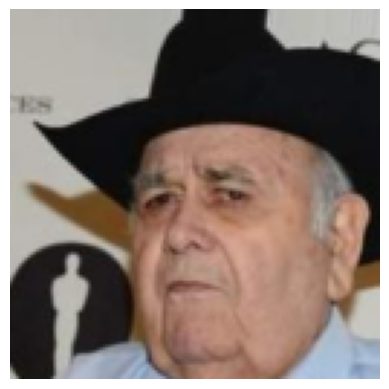

torch.Size([1, 3, 128, 128])
torch.Size([1, 256, 512])


In [9]:
dataset = Celeba(path, 'test', resize = 128)
tokenizer = ImgTokenizer(128, 8, 512)
data = dataset[10]
plt.imshow(rearrange(data['inp'].detach().numpy(), 'i j k -> j k i'))
plt.axis('off')
plt.show()
data_b = {'inp': data['inp'].unsqueeze(0), 'gt': data['inp'].unsqueeze(0) }
print(data_b['inp'].shape)
token = tokenizer(data_b)
print(token.shape)

In [10]:
TINR = TransInr(64)
img_mlp = TINR(data_b)
print(img_mlp)

HypoMlp(
  (relu): ReLU()
)


In [13]:
print(TINR.wtokens.shape)

torch.Size([259, 512])


In [4]:
###---Training Loop---###
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import torchvision
import numpy as np
from tqdm import tqdm
from math import pi

# --- Hyperparameters ---
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUT_FILE = 'TransINR_CelebA'

# --- Data Preparation ---
train_dataset = Celeba(path, 'train', resize=128)
val_dataset = Celeba(path, 'val', resize=128)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

# --- Model ---
model = TransInr(n_groups=64).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
#scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS * len(train_loader))
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3,  threshold=0.00006, threshold_mode='abs')
loss_fn = torch.nn.MSELoss()

# --- Utility: Create Coordinate Grid ---
def get_coord_grid(h, w, device):
    y, x = torch.meshgrid(
        torch.linspace(-1, 1, steps=h, device=device),
        torch.linspace(-1, 1, steps=w, device=device),
        indexing='ij'
    )
    coords = torch.stack([x, y], dim=-1)  # (H, W, 2)
    return coords.view(-1, 2)  # (H*W, 2)

# --- Training Loop ---
best_val_loss = 1e10

train_losses = []
val_losses = []
print(f"Training on {DEVICE}")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    prev_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()
        inp = batch['inp'].to(DEVICE)  # (B, 3, H, W)
        B, C, H, W = inp.shape

        coords = get_coord_grid(H, W, DEVICE).repeat(B, 1, 1)  # (4096, 2)
        gt = inp.permute(0, 2, 3, 1).reshape(B, -1, 3)  # (B, H*W, 3)

        
        hypo_net = model({'inp': inp})  # returns configured HypoMlp
        pred = hypo_net(coords)  # (B, H*W, 3)
        loss = loss_fn(pred, gt)

        
        total_loss += loss.item()
        
        # Scales the loss, and calls backward()
        # to create scaled gradients
        loss.backward()
        optimizer.step()
        
        '''del inp, coords, gt, pred, hypo_net, loss
        torch.cuda.empty_cache()
        gc.collect()'''

    
    epoch_loss = total_loss / len(train_loader)
    train_losses.append(epoch_loss)
    pickle.dump(train_losses, open('TransINR_CelebA_lrdrop/train_losses.pkl', 'wb'))
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}")
    
    # --- Validation Loop ---
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            inp = batch['inp'].to(DEVICE)
            B, C, H, W = inp.shape

            coords = get_coord_grid(H, W, DEVICE).repeat(B, 1, 1)  # (4096, 2)
            gt = inp.permute(0, 2, 3, 1).reshape(B, -1, 3)

            hypo_net = model({'inp': inp})
            pred = hypo_net(coords)

            loss = loss_fn(pred, gt)
            total_val_loss += loss.item()
    
    val_loss = total_val_loss / len(val_loader)
    val_losses.append(val_loss)
    pickle.dump(val_losses, open('TransINR_CelebA_lrdrop/val_losses.pkl', 'wb'))
    print(f"[Epoch {epoch+1}] Val Loss: {val_loss:.6f}")
    scheduler.step(val_loss)
        
    
    # --- Save checkpoint if best ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_loss,
            'val_loss': val_loss,
        }
        torch.save(checkpoint, f'TransINR_CelebA_lrdrop/{OUT_FILE}_{epoch}.pth')
        print(f"Saved new best model with Val Loss: {best_val_loss:.6f}")

Training on cuda


Epoch 1/50: 100%|██████████| 1250/1250 [11:26<00:00,  1.82it/s]


[Epoch 1] Loss: 0.0383


Epoch 1/50 [Val]: 100%|██████████| 157/157 [00:33<00:00,  4.66it/s]


[Epoch 1] Val Loss: 0.018712
Saved new best model with Val Loss: 0.018712


Epoch 2/50: 100%|██████████| 1250/1250 [11:26<00:00,  1.82it/s]


[Epoch 2] Loss: 0.0148


Epoch 2/50 [Val]: 100%|██████████| 157/157 [00:33<00:00,  4.67it/s]


[Epoch 2] Val Loss: 0.011994
Saved new best model with Val Loss: 0.011994


Epoch 3/50: 100%|██████████| 1250/1250 [11:26<00:00,  1.82it/s]


[Epoch 3] Loss: 0.0108


Epoch 3/50 [Val]: 100%|██████████| 157/157 [00:33<00:00,  4.67it/s]


[Epoch 3] Val Loss: 0.009563
Saved new best model with Val Loss: 0.009563


Epoch 4/50: 100%|██████████| 1250/1250 [11:25<00:00,  1.82it/s]


[Epoch 4] Loss: 0.0089


Epoch 4/50 [Val]: 100%|██████████| 157/157 [00:33<00:00,  4.67it/s]


[Epoch 4] Val Loss: 0.008133
Saved new best model with Val Loss: 0.008133


Epoch 5/50:  54%|█████▎    | 671/1250 [06:08<05:17,  1.82it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 6/50: 100%|██████████| 1250/1250 [11:26<00:00,  1.82it/s]


[Epoch 6] Loss: 0.0194


Epoch 6/50 [Val]: 100%|██████████| 157/157 [00:33<00:00,  4.65it/s]


[Epoch 6] Val Loss: 0.011525


Epoch 7/50: 100%|██████████| 1250/1250 [11:27<00:00,  1.82it/s]


[Epoch 7] Loss: 0.0100


Epoch 7/50 [Val]: 100%|██████████| 157/157 [00:33<00:00,  4.65it/s]


[Epoch 7] Val Loss: 0.009038


Epoch 8/50:  67%|██████▋   | 842/1250 [07:42<03:44,  1.82it/s]


KeyboardInterrupt: 

In [ ]:
(1, 28, 28)

(x, y, v) -> 
((pos_enc(x,y), v ->)
((pos_enc(x,y), v) -> 

(1, ) -> (64, )
(x, ) -> (32, )
(y, ) -> (32, )

cat
 
normalize (maybe, 'try this')